# 3 Vectorization in neural networks (Batchsize)

Huge part of the code has been dervied from the following PyTorch tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

In [1]:
from time import perf_counter, time
import numpy as np # version = 1.24.3
import torch # version = 2.0.0 + cu118
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import random
from tqdm.notebook import tqdm

## Load Dataset

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

take_indices_train = list(range(0, len(trainset), 3))
take_indices_valid = list(range(1, len(testset), 2))

train_subset = torch.utils.data.Subset(trainset, take_indices_train)
valid_subset = torch.utils.data.Subset(testset, take_indices_valid)
# trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

# testloader = torch.utils.data.DataLoader(valid_subset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(len(train_subset))

Files already downloaded and verified
Files already downloaded and verified
16667


### Inspect Dataset

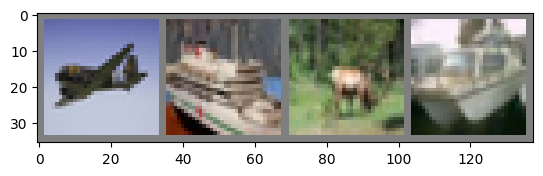

plane ship  deer  ship 


In [21]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Define model and training params

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training

In [21]:
NUM_EPOCHS = 10

loss_epoch_bs = []
valid_accuracy_bs = []
time_for_epoch_bs = []

BATCHSIZE = [64] #, 512] #[4, 16, 64, 256, 512]
for bs in BATCHSIZE:
    trainloader = torch.utils.data.DataLoader(train_subset, batch_size=bs,
                                            shuffle=True, num_workers=4)

    testloader = torch.utils.data.DataLoader(valid_subset, batch_size=bs,
                                            shuffle=False, num_workers=4)

    device = torch.device("cuda")
    net = Net()
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    scaler = torch.cuda.amp.GradScaler(enabled=True)
    loss_epoch = []
    valid_accuracy = []
    time_for_epoch = []

    for epoch in tqdm(range(NUM_EPOCHS)):  # loop over the dataset multiple times
        running_loss = 0.0
        total = 0
        correct = 0
        _t_start = perf_counter()
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                outputs = net(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # print statistics
            running_loss += loss.item()
            # if i % (len(train_subset) // (bs*10)) == 0:    # print every 2000 mini-batches
            #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}, acc: {100 * correct // total}%')
                # running_loss = 0.0
        _t_end = perf_counter()
        time_for_epoch.append(_t_end - _t_start)
        loss_epoch.append(running_loss)

        correct = 0
        total = 0
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                with torch.autocast(device_type='cuda', dtype=torch.float16):
                    # calculate outputs by running images through the network
                    outputs = net(images)

                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc_epoch = 100 * correct // total
        print(f"epoch: {epoch}, val accuracy: {val_acc_epoch}")
        valid_accuracy.append(val_acc_epoch)
    
    loss_epoch_bs.append(loss_epoch)
    valid_accuracy_bs.append(valid_accuracy)
    time_for_epoch_bs.append(time_for_epoch)

print('Finished Training')


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0, val accuracy: 11
epoch: 1, val accuracy: 14
epoch: 2, val accuracy: 14
epoch: 3, val accuracy: 14
epoch: 4, val accuracy: 16
epoch: 5, val accuracy: 23
epoch: 6, val accuracy: 26
epoch: 7, val accuracy: 28
epoch: 8, val accuracy: 30
epoch: 9, val accuracy: 31
Finished Training


In [22]:
print(time_for_epoch)
print(valid_accuracy)
print(loss_epoch)

[12.861581599980127, 13.025183199963067, 13.438129499962088, 12.996883500018157, 12.72336910001468, 12.6322062999825, 12.604110100015532, 12.554656699998304, 12.849772599991411, 12.710531499993522]
[11, 14, 14, 14, 16, 23, 26, 28, 30, 31]
[600.9510655403137, 600.2658658027649, 599.1898894309998, 596.1019265651703, 582.9608707427979, 562.1368412971497, 544.7617032527924, 527.5234583616257, 513.392126083374, 500.3276011943817]
